In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ttest_ind, wilcoxon
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('../mats/2023-nwbc-data.csv')

In [3]:
df.shape

(736626, 95)

In [4]:
df['is_strike'] = 0
strike_events = ['called_strike', 'swinging_strike',
       'foul', 'blocked_ball', 'swinging_strike_blocked', 'hit_by_pitch',
       'foul_tip', 'foul_bunt', 'missed_bunt', 'bunt_foul_tip']
df.loc[df['description'].isin(strike_events), 'is_strike'] = 1

_df = df.loc[:, ['pitcher_name', 'pitch_name', 'is_strike']].groupby(['pitcher_name','pitch_name']).agg(n_pitches = ('is_strike','count')).reset_index()
df2 = df.merge(_df, on=['pitcher_name','pitch_name'])
df2 = df2.loc[df2['n_pitches']>=100]

df2['runs_scored'] = df2['post_bat_score'] - df2['bat_score']

In [5]:
df2.shape

(672545, 98)

In [6]:
df2.iloc[:,-2:].describe()

,n_pitches,runs_scored
count,672545.000000,672545.000000
mean,563.028991,0.028695
std,354.677992,0.209070
min,100.000000,0.000000
25%,290.000000,0.000000
50%,482.000000,0.000000
75%,754.000000,0.000000
max,1848.000000,4.000000


# Earned average run (ERA)

In [7]:
era=(df2
 .loc[:,['pitcher_name','pitcher','runs_scored']]
 .groupby(['pitcher_name','pitcher'],as_index=False)
 .sum())

#Important to know this takes filtered data and counts partial innings as full innings
_df = df2.loc[:,['pitcher','game_pk','inning']].drop_duplicates()
_df = (_df['pitcher']
       .value_counts()
       .to_frame().reset_index()
       .rename(columns={'index':'pitcher'
                        , 'pitcher':'n_innings'}))

era = era.merge(_df, on=['pitcher'])
era['era'] = (era['runs_scored']/era['n_innings'])*9
era.head()

,pitcher_name,pitcher,runs_scored,n_innings,era
0,"Abbott, Cory",676265,25,52,4.326923
1,"Abreu, Albert",656061,12,51,2.117647
2,"Abreu, Bryan",650556,26,81,2.888889
3,"Acevedo, Domingo",642758,32,82,3.512195
4,"Adam, Jason",592094,14,77,1.636364


# strike outs

In [8]:
strikeout_events = ['strikeout','strkeout_double_play']
df2['strikeout']=0
df2.loc[df2['events'].isin(strikeout_events), 'strikeout'] = 1
_df = (df2
       .loc[:, ['pitcher_name','pitcher','strikeout']]
       .groupby(['pitcher_name','pitcher'], as_index=False)
       .sum())
era = era.merge(_df, on=['pitcher_name','pitcher'])

In [9]:
#strike outs per 9 innings
era['k9'] = (era['strikeout']/era['n_innings'])*9

In [10]:
era.head()

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,k9
0,"Abbott, Cory",676265,25,52,4.326923,45,7.788462
1,"Abreu, Albert",656061,12,51,2.117647,29,5.117647
2,"Abreu, Bryan",650556,26,81,2.888889,101,11.222222
3,"Acevedo, Domingo",642758,32,82,3.512195,58,6.365854
4,"Adam, Jason",592094,14,77,1.636364,77,9.000000


# fielder-independent pitching (FIP)

In [11]:
df2['walk']= 0
df2.loc[df2['events']=='walk', 'walk']=1
df2['home_run']= 0
df2.loc[df2['events']=='home_run', 'home_run']=1
_df = (df2
        .loc[:, ['pitcher_name','pitcher','walk', 'home_run']]
        .groupby(['pitcher_name','pitcher'])
        .sum())
era = era.merge(_df, on=['pitcher_name','pitcher'])

In [12]:
era['fip'] = 3+(((era['home_run']*13) + (era['walk']*3) - (era['strikeout']*2)) / (era['n_innings']))

In [13]:
era.head()

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,k9,walk,home_run,fip
0,"Abbott, Cory",676265,25,52,4.326923,45,7.788462,25,12,5.711538
1,"Abreu, Albert",656061,12,51,2.117647,29,5.117647,11,1,2.764706
2,"Abreu, Bryan",650556,26,81,2.888889,101,11.222222,30,2,1.938272
3,"Acevedo, Domingo",642758,32,82,3.512195,58,6.365854,13,9,3.487805
4,"Adam, Jason",592094,14,77,1.636364,77,9.000000,15,5,2.428571


# Data Visualization

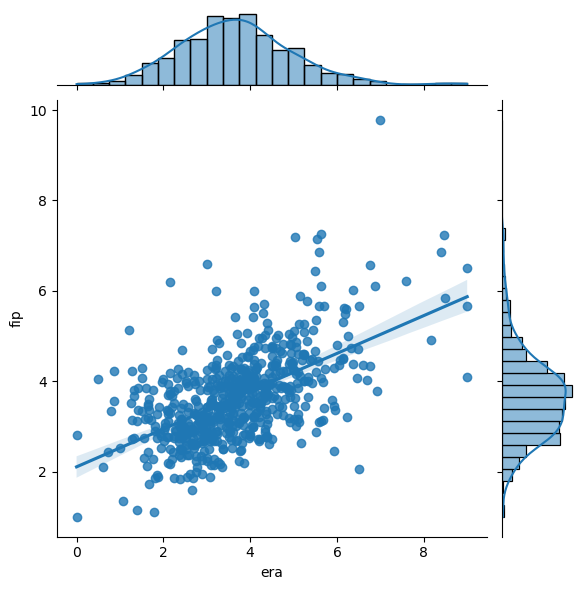

In [14]:
sns.jointplot(data=era, x='era', y='fip', kind='reg')
plt.show()

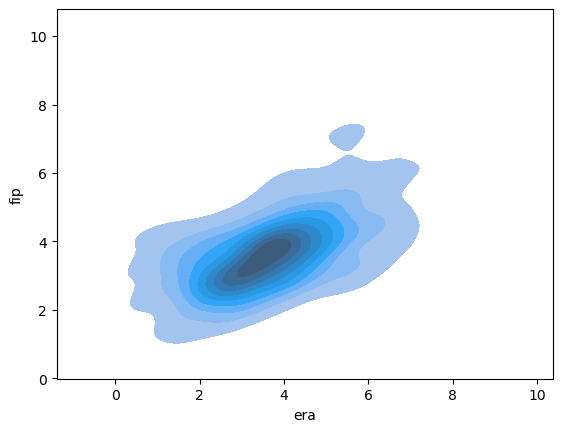

In [15]:
sns.kdeplot(data=era, x='era', y='fip',fill='True')
plt.show()

#  Stats

In [16]:
era[['fip','era','k9']].describe()

,fip,era,k9
count,632.000000,632.000000,632.000000
mean,3.651918,3.693438,6.801823
std,0.987219,1.345245,2.378781
min,1.000000,0.000000,0.000000
25%,2.987269,2.789156,5.400000
50%,3.584524,3.613715,6.947368
75%,4.137987,4.414468,8.417677
max,9.777778,9.000000,15.464789


In [17]:
era['era'].quantile(.01), era['era'].quantile(.999)

(0.8571428571428571, 9.0)

In [18]:
era.loc[:, ['fip','era','k9']].corr()

,fip,era,k9
fip,1.000000,0.569968,-0.423126
era,0.569968,1.000000,0.013280
k9,-0.423126,0.013280,1.000000


In [19]:
era.loc[:, ['fip','era','k9']].corr()**2

,fip,era,k9
fip,1.000000,0.324864,0.179035
era,0.324864,1.000000,0.000176
k9,0.179035,0.000176,1.000000


In [20]:
era['era_plus'] = (era['era'] / era['era'].mean())*100

In [21]:
era.head()

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,k9,walk,home_run,fip,era_plus
0,"Abbott, Cory",676265,25,52,4.326923,45,7.788462,25,12,5.711538,117.151622
1,"Abreu, Albert",656061,12,51,2.117647,29,5.117647,11,1,2.764706,57.335382
2,"Abreu, Bryan",650556,26,81,2.888889,101,11.222222,30,2,1.938272,78.216787
3,"Acevedo, Domingo",642758,32,82,3.512195,58,6.365854,13,9,3.487805,95.092829
4,"Adam, Jason",592094,14,77,1.636364,77,9.000000,15,5,2.428571,44.304613


In [22]:
era['era_plus'].describe()

count    632.000000
mean     100.000000
std       36.422553
min        0.000000
25%       75.516510
50%       97.841486
75%      119.521900
max      243.675373
Name: era_plus, dtype: float64

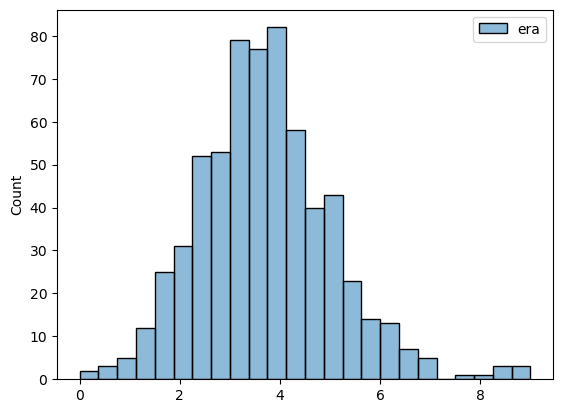

In [23]:
sns.histplot([era['era']])
plt.show()

# visualization

In [24]:
#fucntion to perform statistical analysis
def make_corr(era, super_title = ''):

    #product moment correlation
    r = pearsonr(era['era'], era['fip'])
    r2 = r[0]**2
    r[0], r2, r[-1]
    #rank order correlation
    #non normal distribution 30% explained variance
    sr= spearmanr(era['era'],era['fip'])
    sr2= sr[0]**2
    sr[0], sr2, sr[-1]
    #t-test
    t= ttest_ind(era['era'],era['fip'])
    t[0], t[-1]
    #rmse
    rmse= mean_squared_error(era['era'],era['fip'])**.5
    title= f"""
    ERA * FIP
    {super_title}
    Pearson r: {round(r[0],3)} P-value: {round(r[-1],3)}
    Spearmen r: {round(sr[0],3)} P-value: {round(sr[-1],3)}
    T-test: {round(t[0],3)} P-value: {round(t[1],3)}
    RMSE: {round(rmse,3)}
    """
    sns.jointplot(data=era, x='era',y ='fip', kind='reg')
    plt.title(title)
    plt.show()


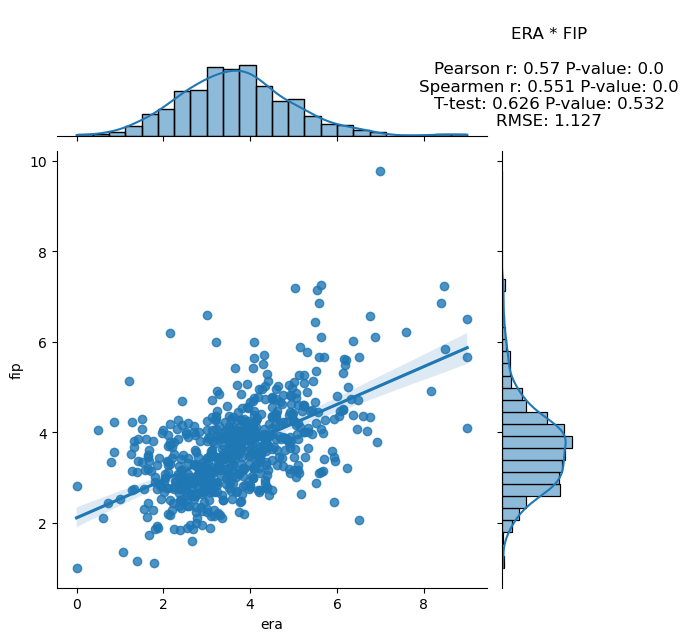

In [25]:
make_corr(era)

In [38]:
#using traintset split instead of manually splitting
samp1, samp2 = train_test_split(era,random_state=42)

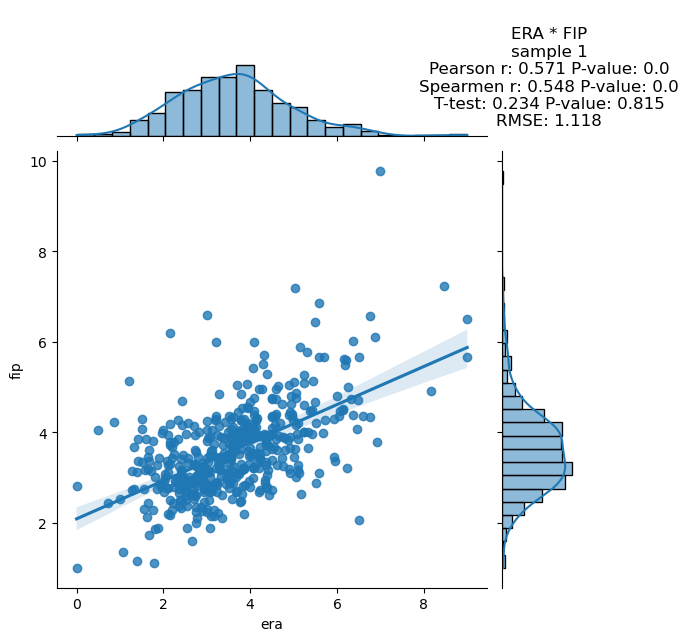

In [41]:
make_corr(samp1, 'sample 1')

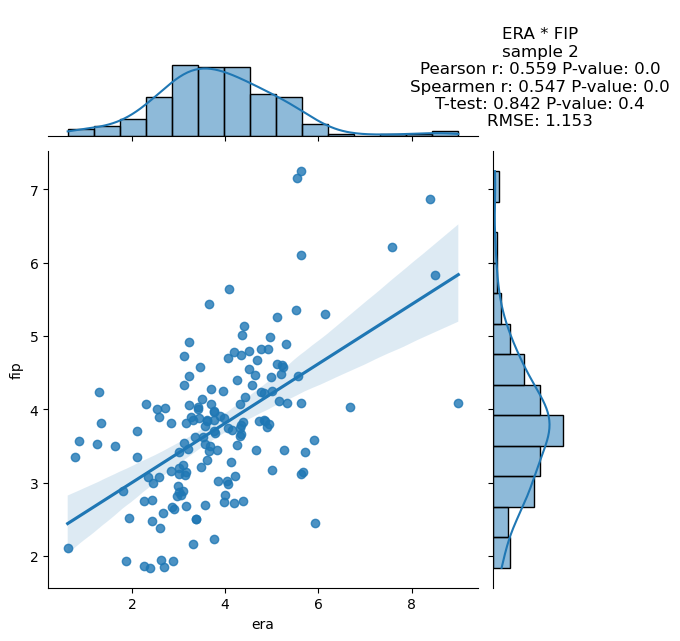

In [42]:
make_corr(samp2, 'sample 2')

# stats part 2

In [29]:
era.head()

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,k9,walk,home_run,fip,era_plus
0,"Abbott, Cory",676265,25,52,4.326923,45,7.788462,25,12,5.711538,117.151622
1,"Abreu, Albert",656061,12,51,2.117647,29,5.117647,11,1,2.764706,57.335382
2,"Abreu, Bryan",650556,26,81,2.888889,101,11.222222,30,2,1.938272,78.216787
3,"Acevedo, Domingo",642758,32,82,3.512195,58,6.365854,13,9,3.487805,95.092829
4,"Adam, Jason",592094,14,77,1.636364,77,9.000000,15,5,2.428571,44.304613


In [30]:
era['k9'].describe()

count    632.000000
mean       6.801823
std        2.378781
min        0.000000
25%        5.400000
50%        6.947368
75%        8.417677
max       15.464789
Name: k9, dtype: float64

<AxesSubplot:xlabel='era', ylabel='k9'>

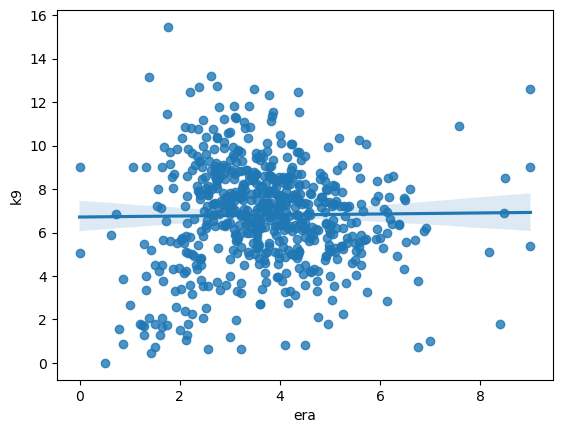

In [31]:
sns.regplot(data=era, x='era', y='k9')

In [32]:
era[['era','k9']].corr()
#alt method
"""
era.loc[:, ['era','k9']].corr()
"""

"\nera.loc[:, ['era','k9']].corr()\n"

In [33]:
wilcoxon(era['era'], era['fip'])

WilcoxonResult(statistic=92654.0, pvalue=0.2267811981151311)

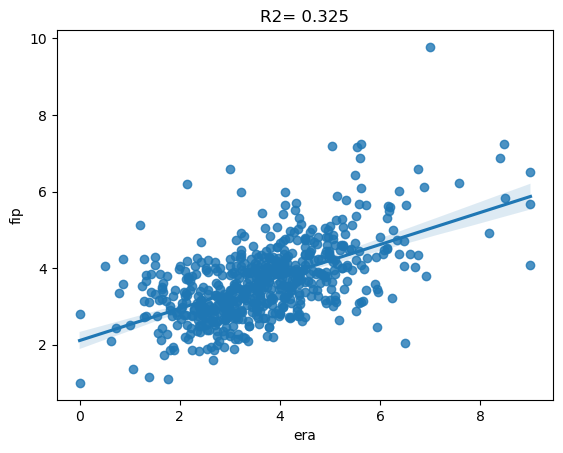

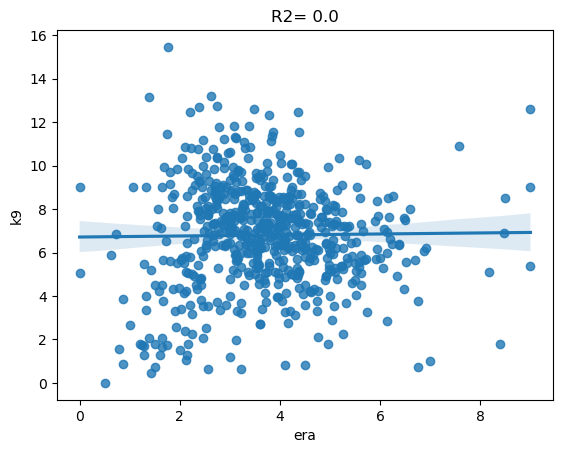

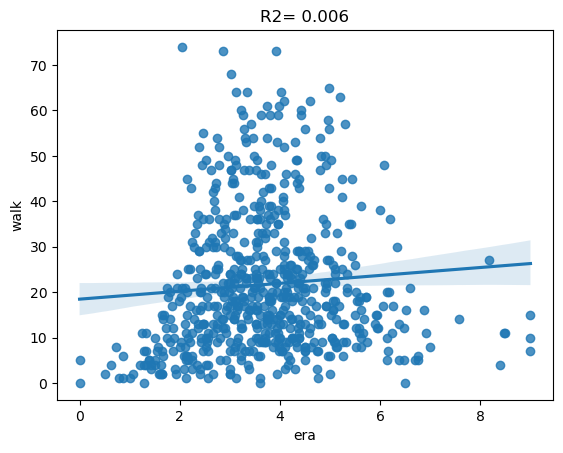

In [34]:
for col in ['fip','k9','walk']:
    r2= pearsonr(era['era'], era[col])[0]**2
    sns.regplot(data=era,x='era',y=col, )
    plt.title(f"R2= {round(r2,3)}")
    plt.show()

# Regression analysis

In [83]:
X = era[['fip', 'k9', 'home_run', 'walk']]
y= era['era']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
model = LinearRegression()
model.fit(X_train,y_train)
test_pred= model.predict(X_test)
train_pred=model.predict(X_train)
test_pred

array([4.245296  , 3.69365958, 4.17280966, 3.92575515, 4.09143036,
       4.39209178, 2.01982003, 4.14658064, 2.52504881, 4.27038694,
       3.41894999, 3.5631315 , 2.48256476, 3.26925821, 3.574131  ,
       3.35423962, 2.93274668, 2.51247154, 2.95327344, 4.07988318,
       3.31701512, 2.46734698, 3.84704648, 2.53330948, 4.54646213,
       4.15495659, 3.83896463, 3.19430213, 3.88738196, 3.48558331,
       3.71732339, 3.86506591, 4.62382221, 3.35310955, 2.1183911 ,
       4.01694879, 5.06297905, 3.75412299, 4.41790307, 4.10669755,
       4.19935554, 4.25899767, 3.30274792, 4.09957744, 3.78517598,
       3.79397014, 3.93381011, 4.01417885, 4.53208327, 3.93930262,
       2.55634408, 2.28913627, 2.38378422, 2.69452297, 2.91807616,
       4.48123761, 2.64470017, 2.91603242, 3.3077796 , 4.08281648,
       2.77503281, 3.22732417, 4.77844807, 3.35640135, 5.95504737,
       5.41388913, 4.00734145, 5.57819311, 2.92895383, 4.64256179,
       3.59591063, 3.53056302, 3.88475803, 3.16892878, 4.41372

In [93]:
r2= pearsonr(y_test, test_pred)[0]**2
rmse = mean_squared_error(y_test, test_pred)**.05
r2, rmse

(0.3824080424667531, 1.0072715051867829)

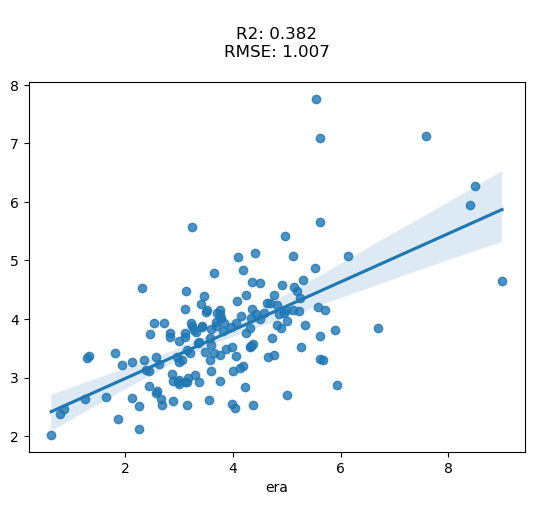

In [94]:
sns.regplot(data=test, x=y_test, y=test_pred)
title = f"""
R2: {round(r2, 3)}
RMSE: {round(rmse,3)}
"""
plt.title(title)
plt.show()

In [95]:
print( f'{r2_score(y_train, train_pred).round(2)} is the r2 of our training data')
print( f'{r2_score(y_test, test_pred).round(2)} is the r2 of our test data')

0.42 is the r2 of our training data
0.37 is the r2 of our test data


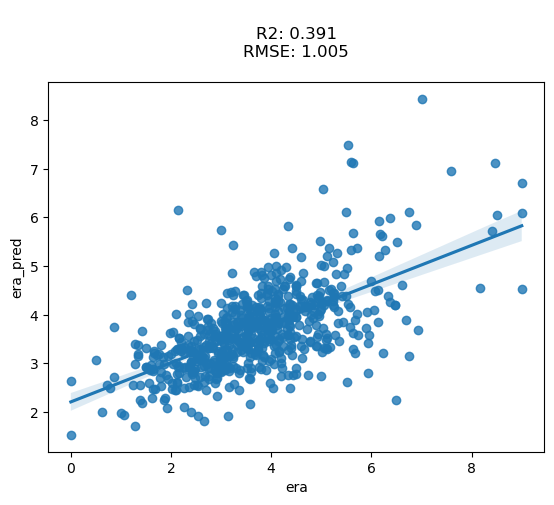

In [121]:
target = 'era'
features = ['fip','k9']
kf = KFold(5, shuffle=True, random_state=1)

oos_preds = pd.Series(dtype=float)

for train_index, test_index in kf.split(era):
    train = era.loc[train_index]
    test = era.loc[test_index]
    
    model = LinearRegression()
    model.fit(train.loc[:, features], train[target])
    test[f"{target}_pred"] = model.predict(test.loc[:, features])
    oos_preds = pd.concat([oos_preds, test[f"{target}_pred"]])
    
era[f"{target}_pred"] = oos_preds

r2= pearsonr(era[target], era[f"{target}_pred"])[0]**2
rmse = mean_squared_error(era[target], era[f"{target}_pred"])**.05
title=f"""
R2: {round(r2, 3)}
RMSE: {round(rmse, 3)}
"""

sns.regplot(data=era, x=target, y=f"{target}_pred")
plt.title(title)
plt.show()

In [120]:
era.head(20)

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,k9,walk,home_run,fip,era_plus,era_pred
0,"Abbott, Cory",676265,25,52,4.326923,45,7.788462,25,12,5.711538,117.151622,5.823422
1,"Abreu, Albert",656061,12,51,2.117647,29,5.117647,11,1,2.764706,57.335382,2.601689
2,"Abreu, Bryan",650556,26,81,2.888889,101,11.222222,30,2,1.938272,78.216787,2.833945
3,"Acevedo, Domingo",642758,32,82,3.512195,58,6.365854,13,9,3.487805,95.092829,3.507097
4,"Adam, Jason",592094,14,77,1.636364,77,9.000000,15,5,2.428571,44.304613,2.887520
5,"Adon, Joan",672851,50,75,6.000000,48,5.760000,38,9,4.800000,162.450249,4.690346
6,"Akin, Keegan",669211,37,104,3.201923,79,6.836538,21,11,3.461538,86.692200,3.524465
7,"Alberto, Hanser",593643,5,11,4.090909,1,0.818182,3,2,6.000000,110.761533,4.995618
8,"Alcantara, Sandy",645261,65,232,2.521552,207,8.030172,49,16,2.745690,68.271118,3.051215
9,"Alexander, Jason",669920,46,76,5.447368,39,4.618421,28,12,5.131579,147.487726,4.834707
